## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

Number of faces detected: 1


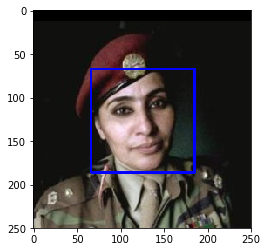

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?   100%
- What percentage of the first 100 images in `dog_files` have a detected human face?   11%


In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

sum_humans =0 
sum_dogs = 0

for file in human_files_short:
    if face_detector(file) == True:
        sum_humans += 1
        
for file in dog_files_short:
    if face_detector(file) == True:
        sum_dogs += 1

print(sum_humans, sum_dogs)

100 11


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector





In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
sum_humans =0 
sum_dogs = 0

for file in human_files_short:
    if dog_detector(file) == True:
        sum_humans += 1
        
for file in dog_files_short:
    if dog_detector(file) == True:
        sum_dogs += 1

print(sum_humans, sum_dogs)

0 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.56it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()


In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()



model.add(Conv2D(filters=16, kernel_size=6, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1744      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model


In [14]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 27s 4ms/step - loss: 4.8869 - acc: 0.0090 - val_loss: 4.8697 - val_acc: 0.0120
Epoch 2/5
6680/6680 [==============================] - 26s 4ms/step - loss: 4.8654 - acc: 0.0120 - val_loss: 4.8489 - val_acc: 0.0084
Epoch 3/5
6680/6680 [==============================] - 26s 4ms/step - loss: 4.8362 - acc: 0.0142 - val_loss: 4.8100 - val_acc: 0.0180
Epoch 4/5
6680/6680 [==============================] - 26s 4ms/step - loss: 4.8000 - acc: 0.0184 - val_loss: 4.7904 - val_acc: 0.0168
Epoch 5/5
6680/6680 [==============================] - 26s 4ms/step - loss: 4.7662 - acc: 0.0256 - val_loss: 4.7746 - val_acc: 0.0204


### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.9139%


---
<a id='step5'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets 

In [24]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_inception_features = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_inception_features['train']
valid_inception = bottleneck_inception_features['valid']
test_inception = bottleneck_inception_features['test']

bottleneck_resnet_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_resnet_features['train']
valid_resnet = bottleneck_resnet_features['valid']
test_resnet = bottleneck_resnet_features['test']

bottleneck_vgg19_features = np.load('/data/bottleneck_features/DogVGG19Data.npz')
train_vgg19 = bottleneck_vgg19_features['train']
valid_vgg19 = bottleneck_vgg19_features['valid']
test_vgg19 = bottleneck_vgg19_features['test']

bottleneck_xception_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_xception = bottleneck_xception_features['train']
valid_xception = bottleneck_xception_features['valid']
test_xception = bottleneck_xception_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()



In [25]:
model_resnet = Sequential()
model_resnet.add(GlobalAveragePooling2D(input_shape=(1,1,2048)))
model_resnet.add(Dense(133, activation='softmax'))
model_resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [28]:
from keras import optimizers

model_resnet.compile(loss='categorical_crossentropy', 
                     optimizer=optimizers.RMSprop(lr=0.0001), 
                     metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
epochs = 20

checkpointer2 = ModelCheckpoint(filepath='saved_models/resnet.weights.best.hdf5', 
                               verbose=1, save_best_only=True)

history_resnet = model_resnet.fit(train_resnet, train_targets, 
                    validation_data=(valid_resnet, valid_targets), 
                    epochs=epochs, batch_size=20, callbacks=[checkpointer2], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 286us/step - loss: 3.7646 - acc: 0.2135 - val_loss: 2.5431 - val_acc: 0.4719
Epoch 2/20
6680/6680 [==============================] - 2s 228us/step - loss: 1.7835 - acc: 0.6472 - val_loss: 1.4890 - val_acc: 0.6599
Epoch 3/20
6680/6680 [==============================] - 2s 226us/step - loss: 1.0582 - acc: 0.7852 - val_loss: 1.0909 - val_acc: 0.7377
Epoch 4/20
6680/6680 [==============================] - 1s 222us/step - loss: 0.7523 - acc: 0.8341 - val_loss: 0.9043 - val_acc: 0.7629
Epoch 5/20
6680/6680 [==============================] - 1s 224us/step - loss: 0.5916 - acc: 0.8642 - val_loss: 0.7995 - val_acc: 0.7784
Epoch 6/20
6680/6680 [==============================] - 1s 224us/step - loss: 0.4895 - acc: 0.8855 - val_loss: 0.7294 - val_acc: 0.7856
Epoch 7/20
6680/6680 [==============================] - 2s 226us/step - loss: 0.4229 - acc: 0.8957 - val_loss: 0.6855 - val_acc: 0.7928
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
model_resnet.load_weights('saved_models/resnet.weights.best.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.


model_predictions = [np.argmax(model_resnet.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.4163%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  


In [32]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.


from extract_bottleneck_features import extract_Resnet50

def resnet_predict_dog_breed(img_path):
    
    # Predict dog breed
    bottleneck_features = extract_Resnet50(path_to_tensor(img_path))
    predicted_vector = model_resnet.predict(bottleneck_features)[0]
    predicted_dog_id = np.argmax(predicted_vector)

    predicted_dog_breed_name = dog_names[predicted_dog_id]
    
    return predicted_dog_breed_name

print(resnet_predict_dog_breed('images/Labrador_retriever_06457.jpg'))

94658560/94653016 [==============================] - 2s 0us/step
in/096.Labrador_retriever


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.




### (IMPLEMENTATION) Write your Algorithm

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


def predict_dog_breed(img_path):
    
    num_of_human_faces = face_detector(img_path)
    dog_breed = resnet_predict_dog_breed(img_path)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if dog_detector(img_path):
        plt.imshow(img)
        plt.show()
        print("Looks like a " + dog_breed + '.')
        
    elif num_of_human_faces > 0:
        plt.imshow(img)        
        plt.show()
        print("Hello human!")
        print("You look like a " + dog_breed + '.')
    
    else:
        plt.imshow(img)
        plt.show()
        print("Error!")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!


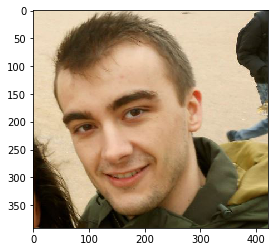

Hello human!
You look like a in/100.Lowchen.


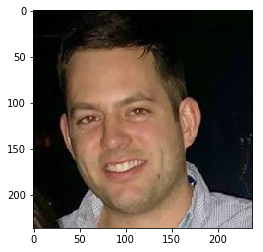

Hello human!
You look like a in/101.Maltese.


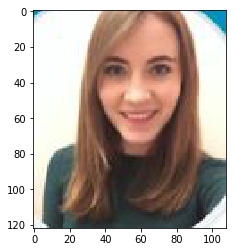

Hello human!
You look like a in/127.Silky_terrier.


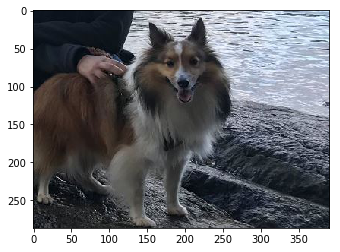

Looks like a in/054.Collie.


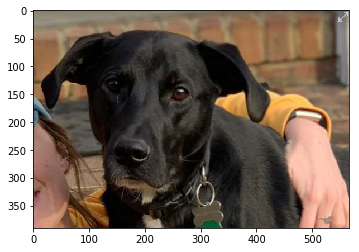

Looks like a in/078.Great_dane.


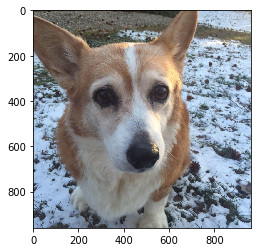

Looks like a in/118.Pembroke_welsh_corgi.


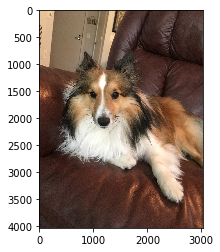

Looks like a in/115.Papillon.


In [49]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.


# human1
predict_dog_breed('images/aleks.JPG')

# human2
predict_dog_breed('images/dan.JPG')

# human3
predict_dog_breed('images/me.JPG')

# Chewie
predict_dog_breed('images/chewie.JPG')

# Rigs
predict_dog_breed('images/rigs.jpeg')

# Misty
predict_dog_breed('images/misty.jpg')

# Chewie test 2
predict_dog_breed('images/chewie2.JPG')





